Advanced lane finding
==================

Imports
---------

In [1]:
import os
import math
import cv2
import time
import copy
import numpy as np
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Constants
---------

In [93]:
WARPED_WIDTH = 500
WARPED_HEIGHT = 500
WARPED_POINTS = np.array([
    [0, WARPED_HEIGHT - 1],
    [0, 0],
    [WARPED_WIDTH - 1, 0],
    [WARPED_WIDTH - 1, WARPED_HEIGHT - 1],
], dtype=np.float32)

THRESHOLD_EDGE = 0.15

WINDOWS_N = 10
WINDOW_HEIGHT = int(WARPED_HEIGHT / float(WINDOWS_N))
WINDOW_WIDTH = int(WARPED_WIDTH * 0.08)
WINDOW_WIDTH = WINDOW_WIDTH + (WINDOW_WIDTH % 2) # make sure it's even
HALF_WINDOW_WIDTH = int(WINDOW_WIDTH / 2)        

DEBUG_DIVIDER_WIDTH = 4

PIXELS_TO_METERS_Y = 3.0 / 100
PIXELS_TO_METERS_X = 3.7 / 350

Utility functions
-----------------

In [3]:
## Region of interest
def build_region_of_interest(shape):
    height = shape[0]
    width = shape[1]
    return np.array([[
        [width * 0.0, height - 1],
        [width * 0.415, height * 0.65],
        [width * 0.585, height * 0.65],
        [width - 1, height - 1],
    ]], dtype=np.int32)

def display_image(image, cmap = None, figsize = None):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)

def read_image(location):
    return mpimg.imread(location)

def constraint(value, min_value, max_value):
    return max(min(value, max_value - 1), min_value)

def draw_window(window, state):
    offset = int((WARPED_WIDTH + DEBUG_DIVIDER_WIDTH) * 3)
    color = (0,255,0) if (window['weight'] >= MIN_WEIGHT) else (255,0,0)
    state.debug_image = cv2.rectangle(
        state.debug_image, 
        (offset + window['left'], window['top']), 
        (offset + window['right'], window['bottom']), 
        color, 
        thickness=2
    )

def draw_curve_warped(state, curve, offset):
    if (curve):
        y_arr = np.arange(0, WARPED_HEIGHT)
        x_arr = y_arr * y_arr * curve.a + y_arr * curve.b + curve.c
        for y in range(0, WARPED_HEIGHT):
            x = x_arr[y]
            if (x >= 0 and x < WARPED_WIDTH):
                x_start = int(x - 2 + offset)
                x_end = int(x + 2 + offset)
                state.debug_image = cv2.line(state.debug_image, (x_start, y),(x_end, y),(255,0,255),1)
    
def draw_curves_warped(state, col):
    offset = int((WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * col)
    draw_curve_warped(state, state.curves['left'], offset)
    draw_curve_warped(state, state.curves['right'], offset)
    
def draw_lane(state):
    img = np.zeros((WARPED_HEIGHT, WARPED_WIDTH, 3))
    if (state.curves['left'] is None or state.curves['right'] is None ):
        return img
    
    ys_left = np.arange(0, WARPED_HEIGHT, dtype=np.int)
    xs_left = state.curves['left'].points_x[ys_left]
    ys_right = np.arange(WARPED_HEIGHT - 1, -1, -1, dtype=np.int)
    xs_right = state.curves['right'].points_x[ys_right]
    
    ys = np.concatenate((ys_left, ys_right))
    xs = np.concatenate((xs_left, xs_right))
    points = np.stack((xs, ys), axis=1)
    cv2.fillPoly(img, np.int_([points]), (0,255, 0))
    return img
    
def put_text(state, text, pos):
    x = state.width_orig + 30
    y = WARPED_HEIGHT + (pos + 1) * 50
    cv2.putText(
            state.debug_image,
            text,
            (x, y), 
            cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA
        )
    
## Add an image to a debug output that contains multiple images: 
## top row: warped image, edge filter output, color filter output, edge+color filter combined output + windows
## bottom row: original image+lines
def add_to_debug_image(img, state, row=0):
    if (state.is_debug):
        # TODO revise this
        if (np.max(img) <= 1):
            img = img * 255
        
        if (row==0):
            left_offset = state.debug_left_pos
            top_offset = 0
        else:
            left_offset = 0
            top_offset = WARPED_HEIGHT
        
        # draw image depending on the number of channels
        if (len(img.shape) == 3 and img.shape[2] == 3):
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1]] = img
        else:
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 0] = img
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 1] = img
            state.debug_image[top_offset:top_offset+img.shape[0], left_offset:left_offset + img.shape[1], 2] = img

        if (row==0):
            state.debug_left_pos += img.shape[1]
            # add divider
            state.debug_image[0:img.shape[0], state.debug_left_pos:state.debug_left_pos + DEBUG_DIVIDER_WIDTH] = 255
            state.debug_left_pos += DEBUG_DIVIDER_WIDTH
            
test_image = read_image('test_images/test6.jpg')
debug_state = None
def get_test_state():
    test_state = State(test_image)
    return test_state

def get_debug_state():
    global debug_state
    if (debug_state is None):
        debug_state = State(test_image, True)
    return debug_state

Curve class
-----------

In [4]:
class Curve:
    a = None
    b = None
    c = None
    weight = 0
    radius = None
    points_x = None
    
    def get_points_x(self):
        points_x = []
        for y in range(0, WARPED_HEIGHT):
            x = int(self.a * y**2 + self.b * y + self.c)
            points_x.append(constraint(x, 0, WARPED_WIDTH))
        return np.array(points_x)
    
    def get_curve_radius(self):
        y_m = WARPED_HEIGHT * PIXELS_TO_METERS_Y
        A_m = self.a * PIXELS_TO_METERS_X / (PIXELS_TO_METERS_Y ** 2)
        B_m = self.b * PIXELS_TO_METERS_X / PIXELS_TO_METERS_Y

        radius = ((1 + (2 * A_m * y_m + B_m) ** 2) ** (1.5)) / abs(2 * A_m)
        return radius
        
    def __init__(self, coeffs_array, weight=0):
        self.a = coeffs_array[0]
        self.b = coeffs_array[1]
        self.c = coeffs_array[2]
        self.weight = weight
        self.radius = self.get_curve_radius()
        self.points_x = self.get_points_x()

State class
-----------

In [5]:
class State:
    is_debug_image = None
    is_debug_video = None
    is_debug = None
    # distortion
    distortion_coefficients = None
    camera_matrix = None
    # warping
    region_of_interest = None
    warp_matrix = None
    unwarp_matrix = None
    # dimensions
    height_orig = None
    width_orig = None
    # windows
    conv_kernel = None
    # line finding
    windows = None
    # curves
    curves = None
    curve_points_num = None
    averaged_curve_radiuses = None
    averaged_pixels = None
    
    debug_image = None
    debug_left_pos = 0
    
    def __init__(self, img, is_debug_image = False, is_debug_video = False):
        self.camera_matrix, self.distortion_coefficients = get_calibration_parameters()
        self.height_orig = img.shape[0]
        self.width_orig = img.shape[1]
        self.region_of_interest = build_region_of_interest(img.shape[0:2])
        
        try:
            self.conv_kernel = get_conv_kernel(WARPED_WIDTH)
        except NameError:
            print("conv_kernel is not defined yet")
        try:
            self.warp_matrix = get_warp_matrix(self.region_of_interest)
        except NameError:
            print("warp_matrix is not defined yet")
        try:
            self.unwarp_matrix = get_unwarp_matrix(self.region_of_interest)
        except NameError:
            print("unwarp_matrix is not defined yet")
            
        self.is_debug_video = is_debug_video
        self.is_debug_image = is_debug_image
        self.is_debug = self.is_debug_video or self.is_debug_image
        self.curve_points_num = { 'left':0, 'right':0 }
        self.averaged_curve_radiuses = { 
            'left': { 'radius': 0, 'weight': 0 }, 
            'right': { 'radius': 0, 'weight': 0 }
        }
        self.curves = { 'left': None, 'right': None }
        if (self.is_debug):
            self.debug_image = np.zeros((
                self.height_orig + WARPED_HEIGHT, 
                max(self.width_orig, (WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * 4),
                3
            ))

Camera calibration and undistortion
------------------------------------------

conv_kernel is not defined yet
warp_matrix is not defined yet
unwarp_matrix is not defined yet


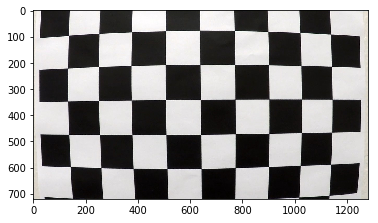

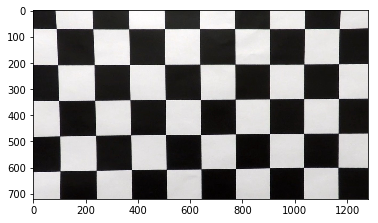

In [6]:
def init_calibration_parameters():
    # termination criteria for cv2.cornerSubPix()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)    

    cal_images = os.listdir("./camera_cal")
    cal_columns = 9
    cal_rows = 6
    obj_points = []
    img_points = []
    obj_points_batch = np.zeros((cal_rows * cal_columns, 3), np.float32)
    obj_points_batch[:,:2] = np.mgrid[0:cal_columns, 0:cal_rows].T.reshape(-1, 2)
    gray = None
    for i, file_name in enumerate(cal_images):
        img = read_image('./camera_cal/' + file_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        is_found, corners = cv2.findChessboardCorners(gray, (cal_columns, cal_rows))
        if (is_found):
            corners = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)          
            obj_points.append(obj_points_batch)
            img_points.append(corners.astype('float32'))
            
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, gray.shape[::-1], None, None)
    return cameraMatrix, distCoeffs

camera_matrix = None 
dist_coeffs = None
def get_calibration_parameters():
    global camera_matrix
    global dist_coeffs
    if (camera_matrix is None or dist_coeffs is None):
        camera_matrix, dist_coeffs = init_calibration_parameters()
    return camera_matrix, dist_coeffs

def undistort(img, state):
    img_undistorted = cv2.undistort(
        img, 
        state.camera_matrix, 
        state.distortion_coefficients, 
        None, 
        state.camera_matrix
    )
    return img_undistorted

# Test
#
img = read_image('./camera_cal/calibration1.jpg')
state = get_test_state()
display_image(img)
und_img = undistort(img, state)
display_image(und_img)

Warping
----------

conv_kernel is not defined yet


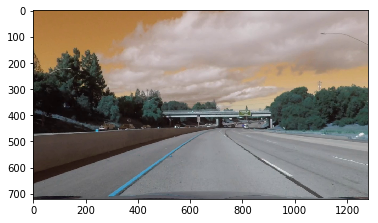

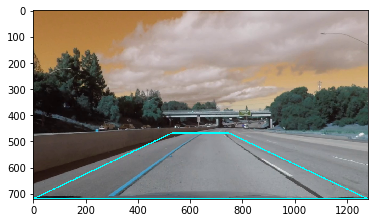

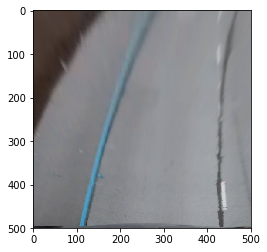

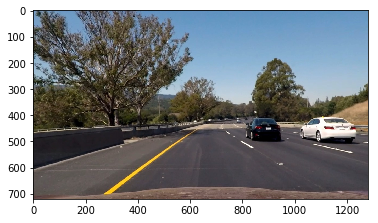

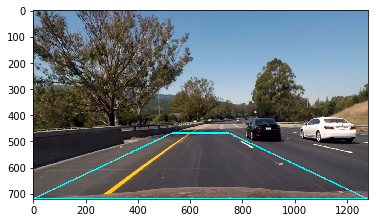

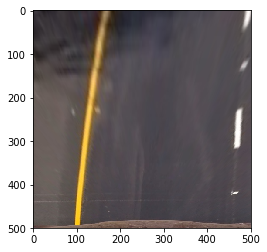

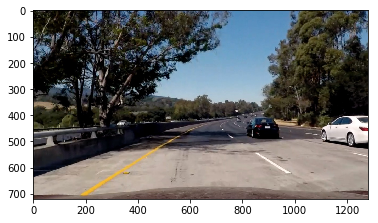

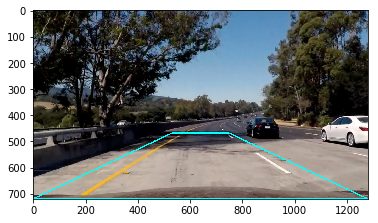

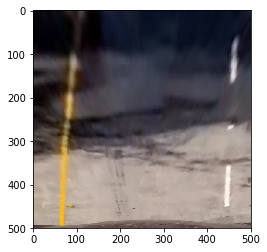

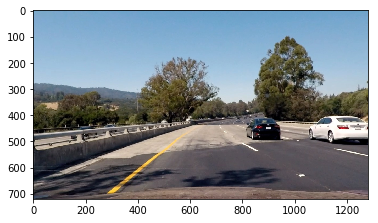

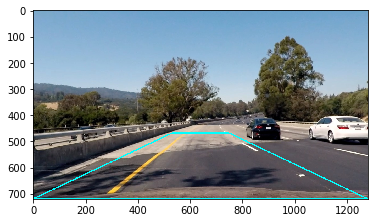

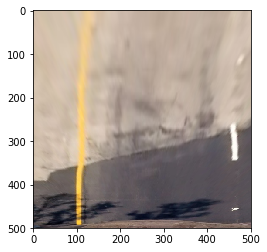

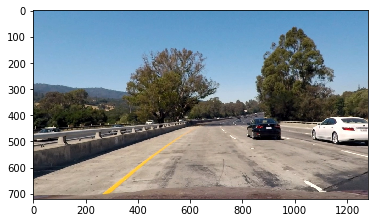

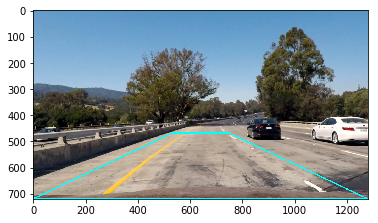

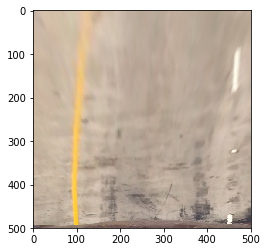

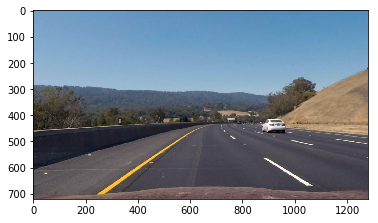

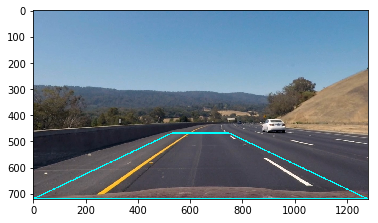

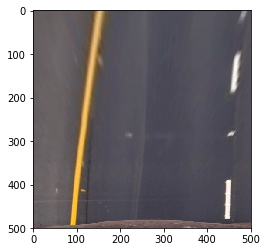

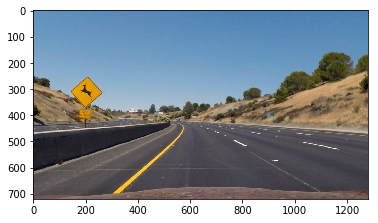

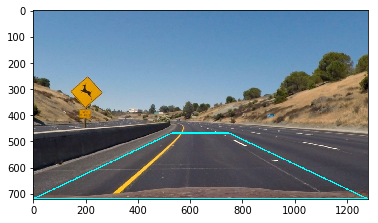

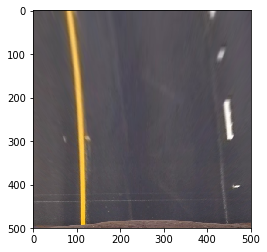

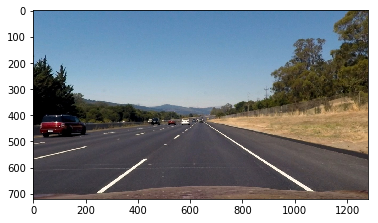

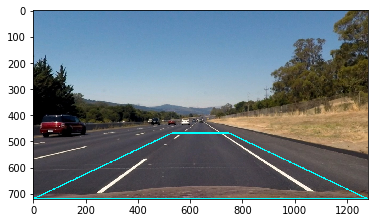

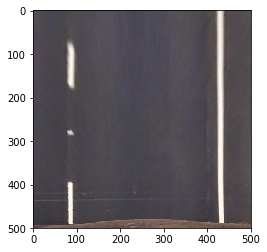

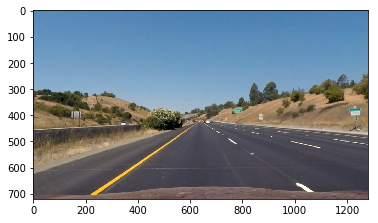

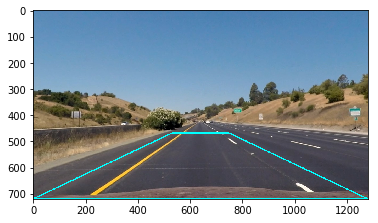

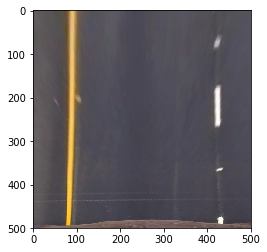

In [7]:
def get_warp_matrix(region_of_interest):
    M = cv2.getPerspectiveTransform(np.array(region_of_interest[0], dtype=np.float32), WARPED_POINTS)
    return M

def get_unwarp_matrix(region_of_interest):
    M = cv2.getPerspectiveTransform(WARPED_POINTS, np.array(region_of_interest[0], dtype=np.float32))
    return M

def warp(img, state):
    warped_image = cv2.warpPerspective(img, state.warp_matrix, (WARPED_WIDTH, WARPED_HEIGHT))
    add_to_debug_image(warped_image, state)
    return warped_image
    
def unwarp(img, state):
    unwarped_image = cv2.warpPerspective(img, state.unwarp_matrix, (state.width_orig, state.height_orig))
    return unwarped_image
    
def test_undistort_and_warp(img, state):
    img_undistorted = undistort(img, state)
    display_image(img_undistorted)
    img_regions = cv2.polylines(img_undistorted.copy(), state.region_of_interest, True, (0, 255, 255), thickness = 3)
    display_image(img_regions)
    img_warped = warp(img_undistorted, state)
    display_image(img_warped)
    
# Test

img = read_image('./camera_cal/calibration5.jpg')
state = get_test_state()    
for i, file_name in enumerate(os.listdir("./test_images")):
    if (file_name.endswith(".jpg")):
        test_undistort_and_warp(read_image("./test_images/" + file_name), state)

Edges
-------

In [8]:
THRESHOLD_EDGE = 0.05
def get_binary_image_with_edge_pixels(img, state):
    MAX_EDGE_VALUE = 163200.0 # cv2.getDerivKernels()&np.outer()
    ## Sobel
    abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=7))
    one_layer = np.max(abs_sobel, axis=2)
    img_sobel = one_layer / MAX_EDGE_VALUE
    img_binary = np.zeros_like(img_sobel)
    img_binary[img_sobel > THRESHOLD_EDGE] = 1
    return img_binary

def test_get_binary_image_with_edge_pixels(img):
    # preparation
    state = get_test_state()
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    display_image(img_warped)
    display_image(get_binary_image_with_edge_pixels(img_warped, state), cmap='gray')

# Test
#
# for i, file_name in enumerate(os.listdir("./test_images")):
#     if (file_name.endswith(".jpg")):
#         print(file_name)
#         test_get_binary_image_with_edge_pixels(read_image("./test_images/" + file_name))

White line
----------

In [9]:
def get_white_line_signals(img, state):
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    CONVOLUTION_SIZE = int(WARPED_HEIGHT / 5)
    conv_vector = np.ones(CONVOLUTION_SIZE) / CONVOLUTION_SIZE
    light_matrix = img_hls[:, :, 1]
    center_light_matrix = light_matrix[:, int(WARPED_WIDTH / 4):int(WARPED_WIDTH * 3 / 4)]
    average_light_vector = np.percentile(center_light_matrix, 98, axis=1)
    convolved_vector = np.convolve(average_light_vector, conv_vector, 'valid')
    # pad with edge averages
    uncovered_area_size = WARPED_HEIGHT - len(convolved_vector)
    convolved_vector = np.concatenate((
        np.ones((int(uncovered_area_size / 2))) * convolved_vector[0],
        convolved_vector,
        np.ones((uncovered_area_size - int(uncovered_area_size / 2))) * convolved_vector[-1],
    ))
    
    convolved_matrix = np.dot(
        convolved_vector.reshape((WARPED_HEIGHT, 1)), 
        np.ones((WARPED_WIDTH)).reshape((1, WARPED_WIDTH))
    )
    
    binary = np.zeros_like(light_matrix)
    binary[light_matrix > convolved_matrix + 20] = 1
    
    return binary

def test_get_white_line_signals(img):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_white_line_signals(img_warped, state)
    display_image(binary_image, cmap='gray')

# test_get_white_line_signals(read_image("./test_images/img_from_video_0.jpg"))

# files = os.listdir("./test_images")
# for i, file_name in enumerate(files):
#     if (file_name.endswith(".jpg")):
#         print(file_name)
#         test_get_white_line_signals(file_name)

Yellow line
------------

In [10]:
def get_binary_image_with_yellow_pixels(img, state):
#     img_blur = np.uint8(cv2.GaussianBlur(img, (3,3), 0))
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_h = np.zeros_like(img_hls[:,:,0])
    binary_h[np.all([15 <= img_hls[:,:,0], img_hls[:,:,0] <= 40], axis=0)] = 1
    return binary_h

def test_get_binary_image_with_yellow_pixels(file_name):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_binary_image_with_yellow_pixels(img_warped, state)
    display_image(binary_image, cmap='gray')

# Test 

# files = os.listdir("./test_images")
# for i, file_name in enumerate(files):
#     if (file_name.endswith(".jpg")):
#         print(file_name)
#         test_get_binary_image_with_yellow_pixels(file_name)

Combine color and edge filters
------------------------------------

In [86]:
def get_combined_line_pixels(img, state):
    edges = get_binary_image_with_edge_pixels(img, state)
    white = get_white_line_signals(img, state)
    yellow = get_binary_image_with_yellow_pixels(img, state)
    white_or_yellow = np.bitwise_or(white, yellow)
    
    conv_size = 3
    conv_matrix = np.zeros((WARPED_HEIGHT, WARPED_WIDTH))
    offset = int(conv_size / 2)
    
    # 2D convolution
    edges_sum = np.zeros_like(edges)
    colors_sum = np.zeros_like(white_or_yellow)
    for i in range(conv_size):
        for j in range(conv_size):
            edges_addend = np.zeros_like(edges)
            edges_addend[0:WARPED_HEIGHT - j, 0:WARPED_WIDTH - i] = edges[j:WARPED_HEIGHT, i:WARPED_WIDTH]
            edges_sum += edges_addend
            colors_addend = np.zeros_like(white_or_yellow)
            colors_addend[0:WARPED_HEIGHT - j, 0:WARPED_WIDTH - i] = white_or_yellow[j:WARPED_HEIGHT, i:WARPED_WIDTH]
            colors_sum += colors_addend
    
    edges_sum = edges_sum[0:WARPED_HEIGHT - offset, 0:WARPED_WIDTH - offset]
    colors_sum = colors_sum[0:WARPED_HEIGHT - offset, 0:WARPED_WIDTH - offset]
    conv_matrix[offset:WARPED_HEIGHT, offset:WARPED_WIDTH] = np.sqrt(edges_sum * colors_sum)
    conv_matrix = conv_matrix / (conv_size * conv_size)
    
#     figsize = (10,10)
    separate_signals = np.stack((yellow, white, edges), axis=-1) * 255.0
    combined = np.stack((conv_matrix, conv_matrix, conv_matrix), axis=-1) * 255.0
    divider = np.ones((500, 5, 3)) * 255
    
#     print("img.shape: " + str(img.shape))
#     print("separate_signals.shape: " + str(separate_signals.shape))
    
#     print("img.max: " + str(np.max(img)))
#     print("separate_signals.max: " + str(np.max(separate_signals)))
    
#     print("img.min: " + str(np.min(separate_signals)))
#     print("separate_signals.min: " + str(np.min(separate_signals)))
    
    all_stacked = np.ones((500, 1010, 3)) * 255
    all_stacked = np.ones_like(img)
    all_stacked = np.ones((500, 510, 3))
    all_stacked[0:500,0:500,0:3] = img

    all_stacked = np.concatenate((img, divider, separate_signals, divider, combined), axis=1)
    display_image(all_stacked.astype(int),  figsize=(15,15))
    print(conv_matrix[0:25, 100:125])
#     print(all_stacked.shape)
#     display_image(img, figsize=(15,15))
#     display_image(np.stack((yellow, white, edges), axis=-1) * 255.0, figsize=figsize)
#     display_image(np.stack((conv_matrix * 255.0, conv_matrix * 255.0, conv_matrix * 255.0), axis=-1), figsize=figsize)
    add_to_debug_image(np.stack((yellow, white, edges), axis=-1) * 255.0, state)
    add_to_debug_image(conv_matrix * 255.0, state)
    return conv_matrix    
    
def test_get_combined_line_pixels(file_name):
    img = read_image("./test_images/" + file_name)
    state = get_test_state()
    img_undistorted = undistort(img, state)
    img_warped = warp(img_undistorted, state)
    if (file_name.startswith('img_from_video_0')):
        img_warped = cv2.cvtColor(img_warped, cv2.COLOR_BGR2RGB)
    display_image(img_warped)
    binary_image = get_combined_line_pixels(img_warped, state)
    display_image(binary_image, cmap='gray')
    
# Test

# files = os.listdir("./test_images")
# for i, file_name in enumerate(files):
#     if (file_name.endswith(".jpg")):
#         print(file_name)
#         test_get_combined_line_pixels(file_name)

Finding windows
-----------------

In [87]:
# conv kernel for finding peaks in windows
def get_conv_kernel(width):
    conv_kernel_width = int(width * 0.08)
    conv_kernel_width = conv_kernel_width + (conv_kernel_width % 2) + 1 # make it odd
    conv_kernel_midpoint = int(conv_kernel_width / 2.0)
    OFFSET = 100
    conv_kernel = np.concatenate((
        range(OFFSET, OFFSET + conv_kernel_midpoint), 
        range(OFFSET + conv_kernel_midpoint, OFFSET - 1, -1)
    ))
    return conv_kernel
    
def find_peak(img_patch, conv_kernel):
    if (img_patch.shape[1] == 0):
        return 0, 0
    sum_array = np.sum(img_patch, axis=0)
    convolved_array = np.convolve(sum_array, conv_kernel, mode='same')
    offsets = np.absolute(np.arange(convolved_array.shape[0]) - (convolved_array.shape[0] / 2))
    inertia_subtrahen = offsets * 10
    inertia_multiplier = np.power(0.98, offsets)
    values = (convolved_array * inertia_multiplier) - inertia_subtrahen
    peak = np.argmax(values)
    return peak, sum_array.sum()
    
def find_initial_window_x(side, state):
    image = state.averaged_pixels
    y_point = int(WARPED_HEIGHT / 4)
    x_midpoint = int(WARPED_WIDTH / 2)

    x_offset = x_midpoint if side == 'right' else 0 
    x_start = 0 + x_offset
    x_end = x_midpoint + x_offset

    peak, _ = find_peak(image[-y_point:, x_start:x_end], state.conv_kernel)
    
    peak += x_offset
    return peak
    
SEARCH_WIDTH = WINDOW_WIDTH * 2
HALF_SEARCH_WIDTH = int(SEARCH_WIDTH / 2)
MAX_SHIFT = WINDOW_WIDTH * 0.75

def find_next_window(prev_x, i, state):
    image = state.averaged_pixels
    bottom = WARPED_HEIGHT - i * WINDOW_HEIGHT
    top = max(0, (bottom - WINDOW_HEIGHT))
    left = int(prev_x - HALF_SEARCH_WIDTH)
    right = int(prev_x + HALF_SEARCH_WIDTH)
    search_zone = image[top:bottom, left:right]
    
    peak, weight = find_peak(search_zone, state.conv_kernel)
    new_x_center = left + peak
    shift = constraint(new_x_center - prev_x, -MAX_SHIFT, MAX_SHIFT)
    new_x_center = prev_x + shift
    
    window = {
        'left': int(constraint(new_x_center - HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'right': int(constraint(new_x_center + HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'top': int(WARPED_HEIGHT - (i + 1) * WINDOW_HEIGHT),
        'bottom': int(WARPED_HEIGHT - i * WINDOW_HEIGHT),
        'weight': weight,
    }
    return (window, new_x_center)

MIN_DISTANCE_BETWEEN_LINES = 200
def find_window_from_curve(i, side, state):
    image = state.averaged_pixels
    bottom = WARPED_HEIGHT - i * WINDOW_HEIGHT
    top = max(0, (bottom - WINDOW_HEIGHT))
    
    y_arr = np.arange(top, bottom)
    curve = state.curves[side]
    x_arr = y_arr * y_arr * curve.a + y_arr * curve.b + curve.c
    x_curve_average = constraint(int(np.mean(x_arr)), 0, WARPED_WIDTH)

    prev_window = state.windows[side][i]
    prev_x_center = (prev_window['left'] + prev_window['right']) / 2
    if (side == 'left'):
        other_side_window = state.windows['right'][i]
        other_side_center = (other_side_window['left'] + other_side_window['right']) / 2
        x_curve_average = constraint(x_curve_average, 0, other_side_center - MIN_DISTANCE_BETWEEN_LINES)
    elif (side == 'right'):
        other_side_window = state.windows['left'][i]
        other_side_center = (other_side_window['left'] + other_side_window['right']) / 2
        x_curve_average = constraint(x_curve_average, other_side_center + MIN_DISTANCE_BETWEEN_LINES, WARPED_WIDTH)

    x_curve_average = constraint(x_curve_average, prev_x_center - MAX_SHIFT, prev_x_center + MAX_SHIFT)        
    x_curve_average = int(constraint(x_curve_average, 0, WARPED_WIDTH))
    if (i > 0):
        prev_below_x_center = (state.windows[side][i-1]['left'] + state.windows[side][i-1]['right']) / 2
        x_curve_average = int(constraint(x_curve_average, prev_below_x_center - MAX_SHIFT, prev_below_x_center + MAX_SHIFT))
    
    left = constraint(x_curve_average - HALF_SEARCH_WIDTH, 0, WARPED_WIDTH)
    right = constraint(x_curve_average + HALF_SEARCH_WIDTH, 0, WARPED_WIDTH)
    search_zone = image[top:bottom, left:right]
    
    peak, weight = find_peak(search_zone, state.conv_kernel)
    if (weight > MIN_WEIGHT):
        new_x_center = left + peak
        shift = constraint(new_x_center - x_curve_average, -MAX_SHIFT, MAX_SHIFT)
        new_x_center = x_curve_average + shift
    else:
        new_x_center = x_curve_average        
    

    window = {
        'left': int(constraint(new_x_center - HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'right': int(constraint(new_x_center + HALF_WINDOW_WIDTH, 0, WARPED_WIDTH)),
        'top': int(WARPED_HEIGHT - (i + 1) * WINDOW_HEIGHT),
        'bottom': int(WARPED_HEIGHT - i * WINDOW_HEIGHT),
        'weight': weight,
    }
    return window

def get_windows_for_side(side, state):
    windows = []
    if state.curves[side] is None:
        current_x = find_initial_window_x(side, state)
        for i in range(0, WINDOWS_N):
            window, current_x = find_next_window(current_x, i, state)
            windows.append(window)
    else:
        for i in range(0, WINDOWS_N):
            window = find_window_from_curve(i, side, state)
            windows.append(window)

    draw_curves_warped(state, 3)
    draw_curves_warped(state, 0)
    for window in windows:
        draw_window(window, state)
    
    return windows

def get_windows(state):
    image = state.averaged_pixels
    windows_debug_start_x = int((WARPED_WIDTH+DEBUG_DIVIDER_WIDTH) * 3)
    state.debug_image[0:WARPED_HEIGHT, windows_debug_start_x:windows_debug_start_x + WARPED_WIDTH] = np.stack((image, image, image), axis=-1) * 255

    windows = { 'left': [], 'right': [] }
    windows['left'] = get_windows_for_side('left', state)
    windows['right'] = get_windows_for_side('right', state)
    
    return windows

Finding curves
-----------

In [88]:
def get_points_from_window(image, window):
    pixels_in_window = image[window['top']:window['bottom'], window['left']:window['right']]
    pixels_array = pixels_in_window.reshape(-1)

    xx, yy = np.meshgrid(np.arange(window['left'], window['right']), np.arange(window['top'], window['bottom']))
    xx = xx.reshape(-1)
    yy = yy.reshape(-1)
    weights = pixels_array
    weight = np.sum(pixels_array)
    return xx, yy, weights, weight    

MIN_WEIGHT = 100
CURVE_WEIGHT_COEFF = 0.1
def get_curve(windows_for_side, side, state):
    points_x = []
    points_y = []
    pixel_weights = []
    weight = 0
    valid_windows_count = 0
    image = state.averaged_pixels
    for _, window in enumerate(windows_for_side):
        if (window['weight'] < MIN_WEIGHT):
            continue
        else:
            valid_windows_count += 1
        
        window_points_x, window_points_y, window_pixel_weights, window_weight = get_points_from_window(image, window)
        points_x = np.append(points_x, window_points_x)
        points_y = np.append(points_y, window_points_y)
        pixel_weights = np.append(pixel_weights, window_pixel_weights)
        weight += window_weight
    if (valid_windows_count >= 3):
        coeffs = np.polyfit(x=points_y, y=points_x, deg=2, w=pixel_weights)
        curve = Curve(coeffs, weight)
        prev_weight = state.averaged_curve_radiuses[side]['weight']
        prev_radius = state.averaged_curve_radiuses[side]['radius']
        averaged_radius = (curve.radius * weight * CURVE_WEIGHT_COEFF + prev_radius * prev_weight * (1 - CURVE_WEIGHT_COEFF)) / (weight * CURVE_WEIGHT_COEFF + prev_weight * (1 - CURVE_WEIGHT_COEFF))
        state.averaged_curve_radiuses[side]['radius'] = averaged_radius
        state.averaged_curve_radiuses[side]['weight'] = weight * CURVE_WEIGHT_COEFF + prev_weight * (1 - CURVE_WEIGHT_COEFF)
    else:
        if (not state.curves[side] is None):
            curve = copy.copy(state.curves[side])
            curve.weight = 0
            prev_weight = state.averaged_curve_radiuses[side]['weight']
            state.averaged_curve_radiuses[side]['weight'] = prev_weight * (1 - CURVE_WEIGHT_COEFF)
        else:
            curve = None
    state.curve_points_num[side] = len(points_y)
    return curve

X_MESHGRID, _ = np.meshgrid(range(WARPED_WIDTH), range(WARPED_HEIGHT))
def get_curves(state):
    windows = state.windows
    left_curve = get_curve(windows['left'], 'left', state)
    right_curve = get_curve(windows['right'], 'right', state)
    
    return { 'left': left_curve, 'right': right_curve }

AVERAGE_PIXELS_COEFF = 0.15
def get_averaged_pixels(image, state):
    if (state.averaged_pixels is None):
        return image
    else:
        return image * AVERAGE_PIXELS_COEFF + state.averaged_pixels * (1 - AVERAGE_PIXELS_COEFF)

def combine(img_original, img_lines, state):
    img_original = np.array(img_original, dtype=np.int32)
    img_lines = np.array(img_lines, dtype=np.int32)
    result = cv2.addWeighted(img_original, 0.7, img_lines, 0.3, 0)
    add_to_debug_image(result, state, row=1)
    return result

Stats
-----

In [89]:
def get_stats(state):
    left_curve_radius = None
    right_curve_radius = None
    average_radius = None
    position_text = None
    
    curves_count = 0
    
    left_curve = state.curves['left']
    right_curve = state.curves['right']
    if (not left_curve is None):
        left_curve_radius = "{0:.2f}".format(left_curve.radius) + " m."
        curves_count += 1
    if (not right_curve is None):
        right_curve_radius = "{0:.2f}".format(right_curve.radius) + " m."
        curves_count += 1
    
    if (curves_count == 2):
        left_curve_coeffs = np.array([left_curve.a, left_curve.b, left_curve.c])
        right_curve_coeffs = np.array([right_curve.a, right_curve.b, right_curve.c])
        average_coeffs = (left_curve_coeffs + right_curve_coeffs) / 2
        average_curve = Curve(average_coeffs)
        average_radius = "{0:.2f}".format(average_curve.radius) + " m."
        
        y = WARPED_HEIGHT
        left_bottom_x = left_curve.a * (y ** 2) + left_curve.b * y + left_curve.c
        right_bottom_x = right_curve.a * (y ** 2) + right_curve.b * y + right_curve.c
        deviation_from_center_px = WARPED_WIDTH / 2.0 - (right_bottom_x + left_bottom_x) / 2.0
        deviation_from_center_meters = PIXELS_TO_METERS_X * deviation_from_center_px
        side = "right" if deviation_from_center_px > 0 else "left"
        position_text = "{0:.2f}".format(abs(deviation_from_center_meters)) + " m. to the " + side
        
    return [
        "left line radius: " + left_curve_radius,
        "right line radius: " + right_curve_radius,
        "average radius: " + average_radius,
        "position: " + position_text,
    ]
    
def print_stats(state):
    state.debug_image[WARPED_HEIGHT:, state.width_orig:, :] = 0
    img = np.zeros((state.height_orig, state.width_orig, 3))
    if (state.is_debug):
        for pos, stat in enumerate(state.stats):
            put_text(state, stat, pos=pos)
    return img

Pipeline
----------

In [90]:
def pipeline(img, state=None):
    if (state is None):
        state = State(img)
    state.debug_left_pos = 0
    
    img_undistorted = undistort(img, state)

    img_warped = warp(img_undistorted, state)
    
    img_significant_pixels = get_combined_line_pixels(img_warped, state)
    
    state.averaged_pixels = get_averaged_pixels(img_significant_pixels, state)
    
    state.windows = get_windows(state)
    
    state.curves = get_curves(state)
    
    img_lane_warped = draw_lane(state)
    
    img_lane = unwarp(img_lane_warped, state)
    
    state.stats = get_stats(state)
    print_stats(state)
    
    output = combine(img, img_lane, state)
    if (state.is_debug_video == True):
        return state.debug_image.astype(int)
    return output

[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.  

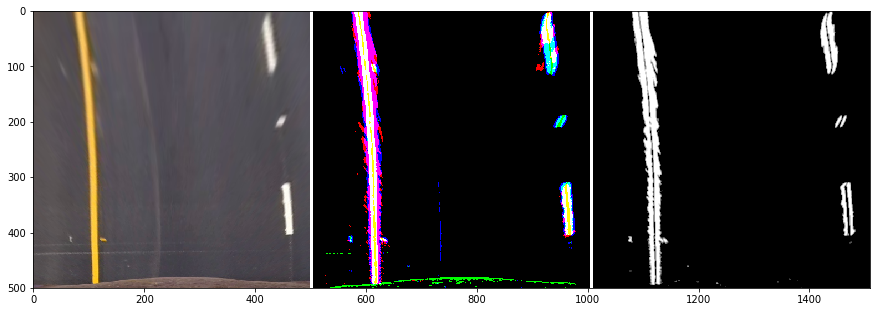

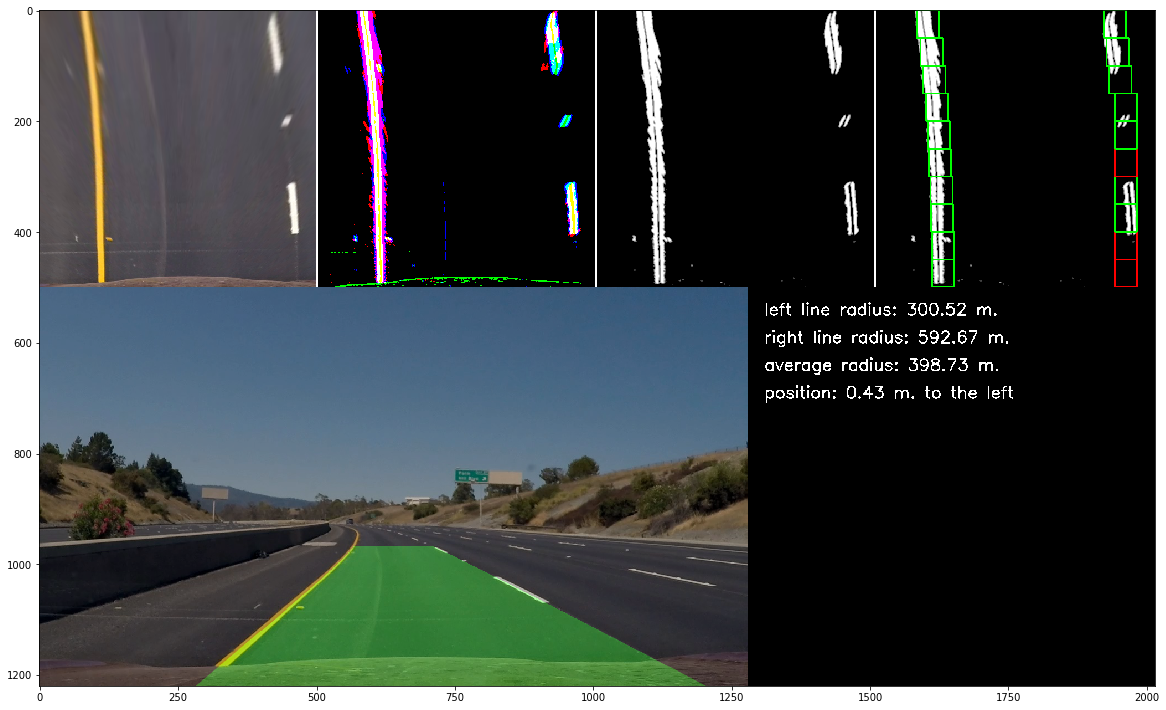

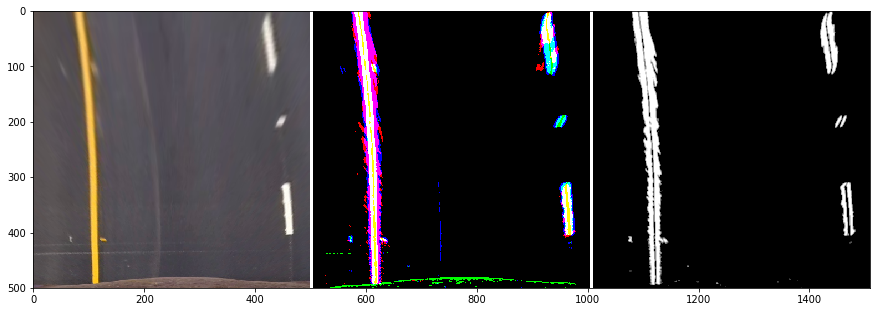

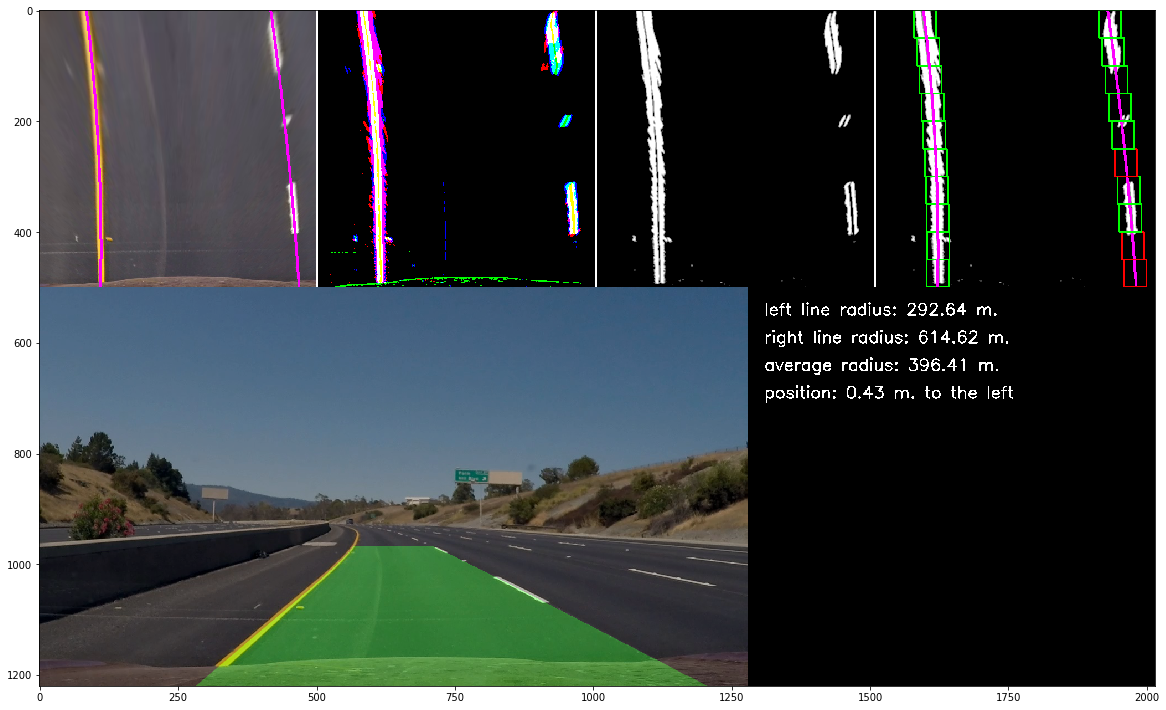

In [91]:
# test_image = read_image('test_images/test6.jpg')
state = State(test_image, True, True)
files = os.listdir("./images_from_video")
files.sort()
for i, file_name in enumerate(files):
    if (file_name.endswith(".jpg")):
        img = read_image("./images_from_video/" + file_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = pipeline(img, state)
        if (i < 12):
            print(file_name)
            display_image(result, figsize=(20, 20))
        if (i > 1):
            break

Video
-------

In [60]:
VIDEOS = ['challenge_video.mp4', 'harder_challenge_video.mp4', 'project_video.mp4']

In [113]:
video_state = None
def get_video_state(img):
    global video_state
    if (video_state is None):
        video_state = State(img, False, is_debug_video=True)
    return video_state

def process_image(img):
    return pipeline(img, get_video_state(img))
#     return write_img(img)

img_n = 0
def write_img(img):
    global img_n
    zero = "0" if img_n < 10 else ""
    cv2.imwrite("images_from_video/img_from_video_" + zero + str(img_n) + ".jpg", img)
    img_n+=1
    return img

In [114]:
def process_video(i, start=0, end=None):
    name = VIDEOS[i]
    if end is None:
        clip = VideoFileClip(name).subclip(start)
    else:
        clip = VideoFileClip(name).subclip(start, end)
    output_name = 'test_videos_output/' + name
    output_clip = clip.fl_image(process_image)
    %time output_clip.write_videofile(output_name, audio=False)
    return HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(output_name))

In [ ]:
video_state = None
process_video(2)#, 10, 20)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [06:42<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 7min 41s, sys: 1min 52s, total: 9min 34s
Wall time: 6min 43s


In [92]:
state.region_of_interest

array([[[   0,  719],
        [ 531,  468],
        [ 748,  468],
        [1279,  719]]], dtype=int32)

## Writeup Template

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./writeup_resources/calibration_chessboard.png "Calibration (chessboard)"
[image2]: ./writeup_resources/calibration_road.png "Calibration (road)"
[image3]: ./writeup_resources/line_signals.png "Line signals"
[image4]: ./writeup_resources/unwarped.png "Unwarped"
[image5]: ./writeup_resources/warped.png "Warped"
[image6]: ./writeup_resources/result_image.png "Result image"
[image7]: ./writeup_resources/line_detection.png "Line detection"

[video1]: ./test_videos_output/project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the cell of the IPython notebook under header `Camera calibration and undistortion` located in "./Project2.ipynb".  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `obj_points_batch` is just a replicated array of coordinates, and `obj_points` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `img_points` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `obj_points` and `img_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To apply distortion correction to an image I use `undistort(img, state)` function that serves as a wrapper for `cv2.undistort(...)`. `state` here is an instance of `State` class that I created to store various values that are useful for the pipeline. Here's an example of a distortion-corrected image (top image - original, bottom - corrected)
![alt text][image2]

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image. The transformations are applied to an already warped image, because that worked better on the images that I tested on. I implemented this in 4 steps:
a. `get_binary_image_with_edge_pixels(img, state)`
This function uses `cv2.Sobel()`, normalizes the result to fit into [0..1] range, using a constant `MAX_EDGE_VALUE`, which is a theoretical max value for `cv2.Sobel()` output, and then thresholds the result using `THRESHOLD_EDGE = 0.05`. The output of this function is a binary image.
b. `get_white_line_signals(img, state)`
There's some light-correction in this function - we know that in the test videos there are parts of the roads that are much brighter than most of the road. To take this into account I convert the image to HLS to get the light matrix, take a central vertical strip of it(to avoid sides of the road), then take a 98-percentile along Y-axis to avoid white lines and the smoothen that vector by convolving it. Then I use that vector to build `convolved_matrix` that consists of just replicated vectors. Finally, I use this expression `binary[light_matrix > convolved_matrix + 20] = 1` to get the binary image. At first I tried dividing `light_matrix` by `convolved_matrix`, but this expression worked best for me.
c. `get_binary_image_with_yellow_pixels(img, state)`
This is a simple thresholding of an HLS image using the Hue channel.
d. `get_combined_line_pixels(img, state)`
This function calls the 3 functions above to get 3 binary images. White and yellow pixels are combined with `np.bitwise_or(white, yellow)`. Then I do a 2D convolution for edge pixels and for color pixels separately to kind of spread the signals to increase the area of intersection between colors and edges. Finally, I combine colors and edges using `np.sqrt(edges_sum * colors_sum)` and then normalize the matrix. As you can tell the result is a 2D matrix, but it's not binary - it kind of contains the strength of the signal.

On the image below you can see: 
* (left) warped image
* (middle) signals: Red channel - yellow color detection, Green channel - white color detection, Blue channel - edge detection
* (right) combined signals

![alt text][image3]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp(img, state)`, which appears in code cell under title `Warping` in the file `Project2.ipynb`. 
The function uses a precalculated `warp_matrix` that is stored in `state`.  I chose the hardcode the source and destination points in the following manner:

```python
# destination
WARPED_POINTS = np.array([
    [0, WARPED_HEIGHT - 1],
    [0, 0],
    [WARPED_WIDTH - 1, 0],
    [WARPED_WIDTH - 1, WARPED_HEIGHT - 1],
], dtype=np.float32)

# source
def build_region_of_interest(shape):
    height = shape[0]
    width = shape[1]
    return np.array([[
        [width * 0.0, height - 1],
        [width * 0.415, height * 0.65],
        [width * 0.585, height * 0.65],
        [width - 1, height - 1],
    ]], dtype=np.int32)
```

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 0, 719      | 0, 499        | 
| 531, 468      | 0, 0      |
| 748, 468     | 499, 0      |
| 1279, 719      | 499, 499        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]
![alt text][image5]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

At this step the input is a 2D matrix that stores combined edge&color signals. First, we need to find windows on an image. If we don't have a curve yet from previous frames, we look for 2 peaks(right/left) in signals in the bottom part of the matrix and place the bottom windows there and then look for the rest of windows based on the bottom windows. If we have a curve from previous frames - we look for new windows along the curve. The X-position of new windows is calculated by the function `find_peak(img_patch, conv_kernel)`, which sums up values along Y-axis and convolves them to find a peak location. You can also see some calculations involving `inertia_...` variables there - this is used to add some friction to make it more likely that the peak will be found closer to the center of the `img_patch` and less likely that the windows will jump around all the time.
When the windows are found, the `get_curve(windows_for_side, side, state)` function goes over them and builds arrays `points_x`, `points_y` and `pixel_weights` which are then used to call `np.polyfit(...)`.

![alt text][image7]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius is calculated by the `get_curve_radius()` function in `Curve` class. It uses hardcoded constants for pixels to meters conversion. 
Position of the vehicle is calculated in function `get_stats(state)` which uses already calculated curves to get the deviation.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in the function `draw_lane()`. Here is an example of my result on a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

When processing a video I use some sort of a weighted average of all previous edge&color frames. The formula that I use is:
`averaged_pixels = image * 0.15 + averaged_pixels * 0.85`
That helps to make line detection more resilient, especially with dashed lines.

I also found it more useful for myself to output not just the result image but also results of other steps of the pipeline, so every frame in my output video contains:
1. warped image with lines
2. edges, white line pixels and yellow line pixels, drawn with different colors on one image
3. combined edges&colors image
4. image with windows and lines on top of combined edges&colors
5. unwarped image with lane
6. curvature and car position 

Here's a [link to my video result](./test_videos_output/project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Issues that I faced: 
1. Bumps on the road and other factors like going uphill/downhill make the warping unreliable
2. Inconsistent light
3. Noise on the road: tree shadows, black lines, white car pool signals
4. Line dashes are not very reliable
5. Sharp turns make the lines go out of the camera's sight

Where the pipeline will likely fail:
1. Sharp turns like in "harder_challenge_video"
2. Night time
3. Dense traffic
4. Some other types of lines
5. Different color of the road
6. Different car (will need to re-adjust warping)

What could I do to make it more robust:
1. Apply image stabilization
2. Implement more comprehensive logic to handle sharp turns OR use a camera with a wider angle